# Random Forest Model Training

This notebook trains a Random Forest ensemble model for mobile price classification.

In [1]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import joblib
import matplotlib.pyplot as plt
import seaborn as sns

## Load Data

In [2]:
train_df = pd.read_csv('../data/train.csv')
test_df = pd.read_csv('../data/test.csv')

X_train = train_df.drop('price_range', axis=1)
y_train = train_df['price_range']
X_test = test_df.drop('price_range', axis=1)
y_test = test_df['price_range']

print(f"Training set: {X_train.shape}")
print(f"Test set: {X_test.shape}")

Training set: (1600, 20)
Test set: (400, 20)


## Preprocessing Pipeline

In [3]:
numeric_cols = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()

preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline([
            ('imputer', SimpleImputer(strategy='mean')),
            ('scaler', StandardScaler())
        ]), numeric_cols)
    ],
    remainder='drop'
)

## Hyperparameter Tuning

In [4]:
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('clf', RandomForestClassifier(random_state=42))
])

# Hyperparameter distribution for RandomizedSearchCV
param_dist = {
    'clf__n_estimators': [50, 100, 200, 300],
    'clf__max_depth': [10, 20, 30, None],
    'clf__min_samples_split': [2, 5, 10],
    'clf__min_samples_leaf': [1, 2, 4],
    'clf__max_features': ['sqrt', 'log2'],
    'clf__bootstrap': [True, False]
}

random_search = RandomizedSearchCV(
    pipeline,
    param_distributions=param_dist,
    n_iter=20,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    random_state=42,
    verbose=1
)

print("Starting hyperparameter tuning...")
random_search.fit(X_train, y_train)

print(f"\nBest parameters: {random_search.best_params_}")
print(f"Best cross-validation score: {random_search.best_score_:.4f}")

Starting hyperparameter tuning...
Fitting 5 folds for each of 20 candidates, totalling 100 fits

Best parameters: {'clf__n_estimators': 300, 'clf__min_samples_split': 5, 'clf__min_samples_leaf': 1, 'clf__max_features': 'log2', 'clf__max_depth': None, 'clf__bootstrap': True}
Best cross-validation score: 0.8706


## Evaluate Model

In [5]:
best_model = random_search.best_estimator_
y_pred = best_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Test Accuracy: 0.8875

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.96      0.95       100
           1       0.83      0.81      0.82       100
           2       0.83      0.83      0.83       100
           3       0.96      0.95      0.95       100

    accuracy                           0.89       400
   macro avg       0.89      0.89      0.89       400
weighted avg       0.89      0.89      0.89       400



## Feature Importance

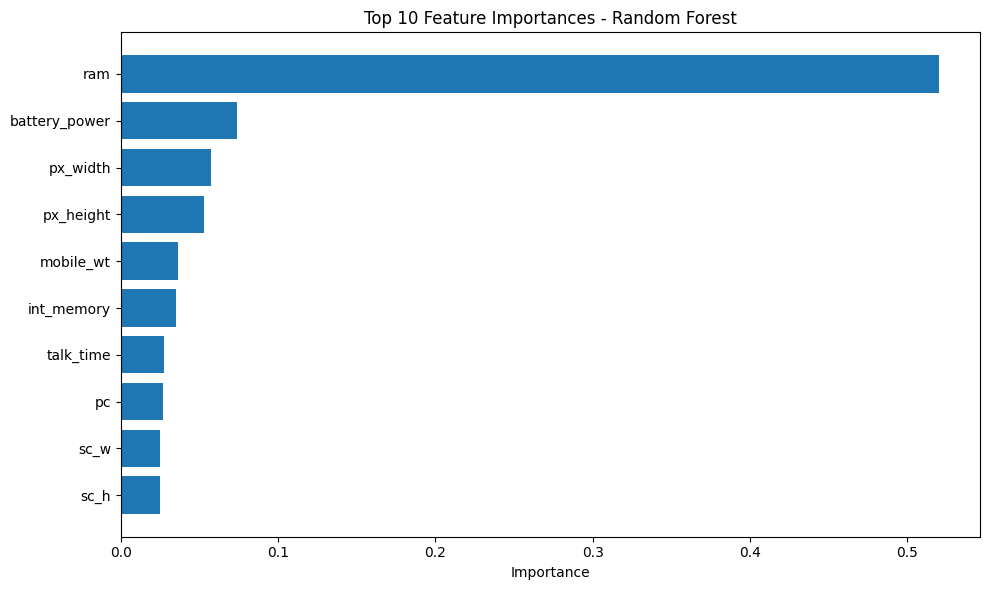


Top 10 Features:
          feature  importance
13            ram    0.520265
0   battery_power    0.073725
12       px_width    0.057147
11      px_height    0.052820
8       mobile_wt    0.036677
6      int_memory    0.035126
16      talk_time    0.027827
10             pc    0.027069
15           sc_w    0.024894
14           sc_h    0.024796


In [6]:
# Get feature importances
feature_importance = best_model.named_steps['clf'].feature_importances_
feature_names = X_train.columns

# Create DataFrame and sort
importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': feature_importance
}).sort_values('importance', ascending=False)

# Plot top 10 features
plt.figure(figsize=(10, 6))
plt.barh(importance_df['feature'][:10], importance_df['importance'][:10])
plt.xlabel('Importance')
plt.title('Top 10 Feature Importances - Random Forest')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

print("\nTop 10 Features:")
print(importance_df.head(10))

## Confusion Matrix

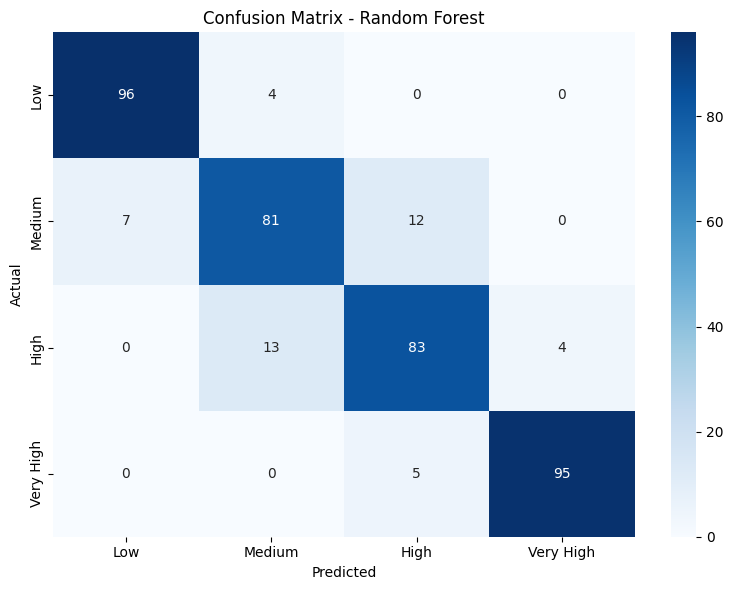

In [7]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Low', 'Medium', 'High', 'Very High'],
            yticklabels=['Low', 'Medium', 'High', 'Very High'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Random Forest')
plt.tight_layout()
plt.show()

## Save Model

In [8]:
model_path = 'saved_models/Random_Forest_model.joblib'
joblib.dump(best_model, model_path)
print(f"Model saved to {model_path}")

Model saved to saved_models/Random_Forest_model.joblib
